# Create masks using images and provided csvs

In [27]:
# import constants and helpers
%run 000_Constants.ipynb

is GPU available: False


In [28]:
import geopandas as gpd

In [29]:
import shapely.geometry

gdf = gpd.read_file(CLEANED_IMAGES_CSV)
gdf = gdf[gdf["is_crossing"]=="True"]
gdf["crossing_location"] = gdf["crossing_location"].apply(lambda row: convert_geojson_list_to_geometry(json.loads(row)))
gdf.geometry = gdf["crossing_location"]
gdf = gdf.set_crs(CRS_4326)
gdf = gdf.to_crs(CRS_2056)
gdf.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/opt/conda/lib/python3.9/site-packages/pandas/io/formats/printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/opt/conda/lib/python3.9/site-packages/pandas/io/formats/printing.p

,image_name,is_crossing,crossing_location,invalid_image,geometry
0,8.52761173248291_47.415306091308594_is_crossin...,True,"(POLYGON ((8.527563 47.415317, 8.527578 47.415...",False,GEOMETRYCOLLECTION (POLYGON ((2682177.071 1252...
3,8.723877906799316_47.50570297241211_is_crossin...,True,"(POLYGON ((8.723818 47.505703, 8.723917 47.505...",False,GEOMETRYCOLLECTION (POLYGON ((2696821.688 1262...
4,8.889448165893555_47.177433013916016_is_crossi...,True,"(POLYGON ((8.889455 47.177391, 8.889403 47.177...",False,GEOMETRYCOLLECTION (POLYGON ((2709973.772 1226...
5,8.531274795532227_47.3640251159668_is_crossing...,True,"(POLYGON ((8.531432 47.364001, 8.531442 47.364...",False,GEOMETRYCOLLECTION (POLYGON ((2682548.479 1246...
8,8.524081230163574_47.2999382019043_is_crossing...,True,"(POLYGON ((8.524131 47.299947, 8.524064 47.299...",False,GEOMETRYCOLLECTION (POLYGON ((2682095.519 1239...


In [30]:
cl = gdf["crossing_location"]
for row in cl:
    if len(row.geoms) > 2:
        print(row)
        break

GEOMETRYCOLLECTION (POLYGON ((8.540147 47.520368, 8.540111 47.520415, 8.540159 47.520426, 8.540164 47.52037, 8.540147 47.520368)), POLYGON ((8.540151 47.520442, 8.5401 47.52043, 8.540061 47.52048, 8.540124 47.520477, 8.540151 47.520442)), POLYGON ((8.539966 47.520532, 8.539905 47.520511, 8.5399 47.520551, 8.539935 47.520562, 8.539966 47.520532)))


In [31]:
for im in DATASET_MASKS_OUT_FOLDER.glob('*.png'):
    !rm -f $im
len(list(DATASET_MASKS_OUT_FOLDER.glob("*.png")))

0

In [32]:
import rasterio as rio
# reduction_factor = 6000

for index, row in gdf.iterrows():
    original_image_path = IMAGES_TIF_FOLDER_CROSSINGS / row["image_name"]
    masked_image_path = DATASET_MASKS_OUT_FOLDER / (original_image_path.with_suffix('.png')).name
    !cp $original_image_path $DATASET_IMAGES_FOLDER

    with rasterio.open(original_image_path) as src:
        masked, out_transform, _ = rasterio.mask.raster_geometry_mask(src, row.geometry, invert=True, crop=False)
        mask = Image.fromarray(masked)
        mask.save(masked_image_path, format='png')
        # maybe needed later, if transform should happen earlier:
        # out_meta = src.meta
        # out_meta.update({"driver": "GTiff", "height": masked.shape[1], "width": masked.shape[2], "transform": out_transform})
        # with rasterio.open(masked_image_path, "w", **out_meta) as dest:
        #     dest.write(masked)


/opt/conda/lib/python3.9/site-packages/rasterio/features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
/opt/conda/lib/python3.9/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


In [33]:
len(list(DATASET_MASKS_OUT_FOLDER.glob("*.png")))

6452

In [38]:
ZIP_RESULT = DATASET_OUT_FOLDER / "dataset.zip"
!python -m zipfile -c $ZIP_RESULT $DATASET_MASKS_OUT_FOLDER $DATASET_IMAGES_FOLDER

In [39]:
!ls -lah $ZIP_RESULT

-rw-r--r-- 1 jovyan 1000 4.0G Nov  5 13:42 /home/jovyan/work/OSMDeepOD/src/pre-processing-data/images/dataset/dataset.zip


## Convert to more usable format

In [34]:
len(list(DATASET_MASKS_OUT_FOLDER.glob("*.png")))

6452

In [74]:
datset_originals_folder = DATASET_OUT_FOLDER / 'original'
!mkdir -p $original

for image_mask in DATASET_MASKS_OUT_FOLDER.glob("*.png"):
    image = IMAGES_TIF_FOLDER_CROSSINGS / (image_mask.stem + '.tif')
    !cp $image_mask $datset_originals_folder
    !cp $image $datset_originals_folder

In [75]:
len(list(datset_originals_folder.glob("*.tif")))

45

In [76]:
reduced = DATASET_OUT_FOLDER / 'reduced'
!mkdir -p $reduced

In [78]:
# import constants and helpers
%run 000_Constants.ipynb

In [79]:
for image in original.glob("*.tif"):
    convert_banded_image(image, out_directory=reduced, bands=[3,1,2], suffix=".tif")

### Important

Adapt to your needs, but don't delete the originals!

In [22]:
# import constants and helpers
%run 000_Constants.ipynb

is GPU available: True


In [23]:
SEGEMENTATION_FOLDER = DATASET_OUT_FOLDER / 'reduced'

In [24]:
from fastai.vision.all import *

In [25]:
def get_images_with_masks():
    images = []
    for im in DATASET_MASKS_OUT_FOLDER.glob("*.png"):
        images.append(SEGEMENTATION_FOLDER / (im.stem + '.tif'))
    return images

get_images_with_masks()[:10]

[Path('/home/jovyan/work/OSMDeepOD/src/pre-processing-data/images/dataset/reduced/8.485750198364258_47.38792419433594_is_crossing_1.tif'),
 Path('/home/jovyan/work/OSMDeepOD/src/pre-processing-data/images/dataset/reduced/9.287238121032715_47.38720703125_is_crossing_1.tif'),
 Path('/home/jovyan/work/OSMDeepOD/src/pre-processing-data/images/dataset/reduced/8.528517723083496_47.19635009765625_is_crossing_1.tif'),
 Path('/home/jovyan/work/OSMDeepOD/src/pre-processing-data/images/dataset/reduced/9.591261863708496_47.266578674316406_is_crossing_1.tif'),
 Path('/home/jovyan/work/OSMDeepOD/src/pre-processing-data/images/dataset/reduced/9.108687400817871_47.56599807739258_is_crossing_1.tif'),
 Path('/home/jovyan/work/OSMDeepOD/src/pre-processing-data/images/dataset/reduced/8.621647834777832_47.33442306518555_is_crossing_1.tif'),
 Path('/home/jovyan/work/OSMDeepOD/src/pre-processing-data/images/dataset/reduced/9.431410789489746_47.32172775268555_is_crossing_1.tif'),
 Path('/home/jovyan/work/OSMD

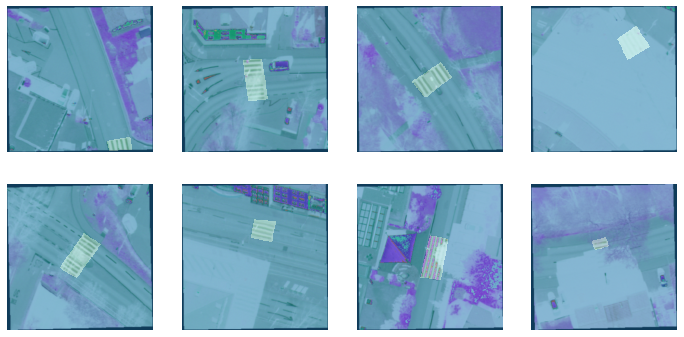

In [26]:
images = get_images_with_masks()[:40]
codes = 256 * ["crossings"]

def label_func(fn):
    return DATASET_MASKS_OUT_FOLDER / f"{fn.stem}.png"


dls = SegmentationDataLoaders.from_label_func(
    SEGEMENTATION_FOLDER,
    bs=8,
    fnames=images,
    label_func=label_func,
    codes = codes,
    item_tfms=Resize(300, method="squish"),
    # batch_tfms=Normalize.from_stats(*imagenet_stats)
)
dls.show_batch(max_n=8)

In [27]:
learn = unet_learner(dls, resnet34)

In [28]:
learn.fine_tune(20)

epoch,train_loss,valid_loss,time
0,2.808162,24.805841,00:02


epoch,train_loss,valid_loss,time
0,6.728262,1.138540,00:02
1,3.678379,0.435104,00:02
2,2.456060,0.144886,00:02
3,1.847676,0.224622,00:02
4,1.468864,0.227519,00:02
5,1.200986,0.142604,00:02
6,1.006038,0.134591,00:02
7,0.858284,0.069462,00:02
8,0.739419,0.093626,00:02
9,0.644263,0.054266,00:02


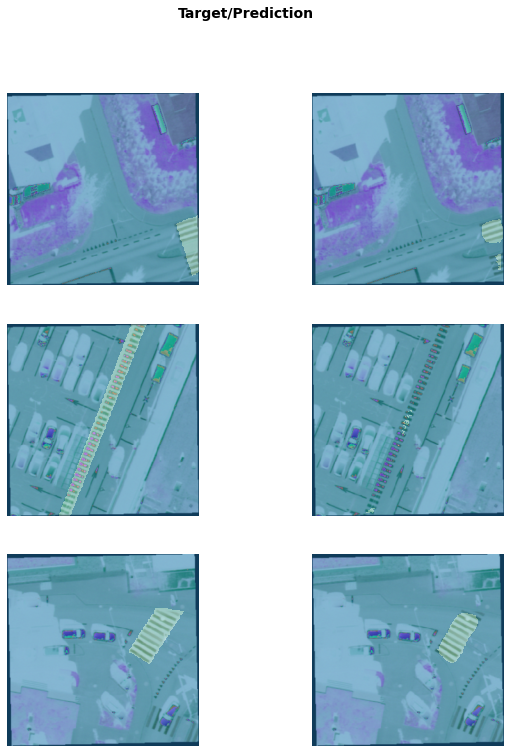

In [33]:
learn.show_results(max_n=3, figsize=(10,12))

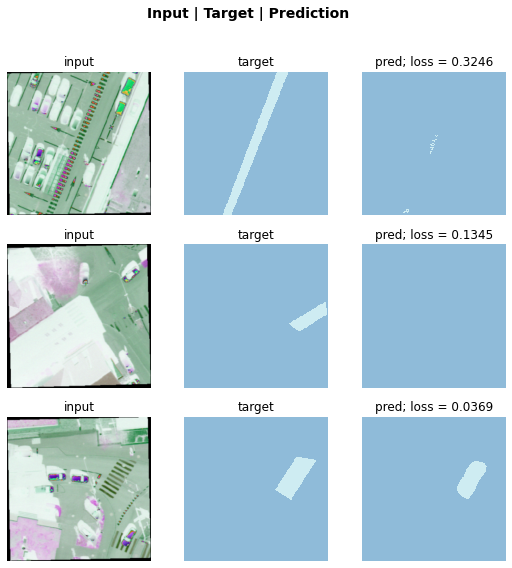

In [30]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

In [21]:
import torch
del learn
torch.cuda.empty_cache()

In [ ]:
# this takes a while!
converted_folder = DEST_FOLDER / "converted"
!mkdir -p $converted_folder
!rm -f $converted_folder/*.tif

# convert to uint8, RGB, still with 4 channels
for fn in DEST_FOLDER.glob("*.tif"):
    dest = converted_folder / fn.name
    !rio convert $fn $dest --overwrite --dtype uint8 --scale-ratio $scale_ratio --co photometric=rgb

In [ ]:
TEST_IMAGE = DEST_FOLDER/'0000000001.tif'

In [ ]:
from rasterio import plot
import numpy as np


def reduce_depth(image, display_min, display_max):
    image -= display_min
    image = np.floor_divide(image, (display_min - display_max + 1) / 256)
    image = image.astype(np.uint8)
    return image


with rasterio.open(TEST_IMAGE) as dataset:
    image = dataset.read()
    reduced_image = reduce_depth(image, 0, 65536)
    plot.show(reduced_image[0], cmap="gray")
    # plot.show(dataset.read(4), cmap="gray")

In [ ]:
from rasterio.plot import show_hist
with rasterio.open(TEST_IMAGE) as dataset:
    show_hist(dataset, bins=50, lw=0.0, stacked=True, alpha=0.3, histtype='stepfilled', title="Histogram")

In [ ]:
with rasterio.open(TEST_IMAGE) as dataset:
    image = dataset.read([1,2,3,4])
    reduced_image = reduce_depth(image, 0, 5536)
    plot.show(image)

In [ ]:
# uint8_image = Path(TEST_IMAGE).with_suffix('.uint8.tif')
# uint8_image

In [ ]:
# scale_ratio = float(255/65536)
# print(scale_ratio)
# !rio convert $TEST_IMAGE $uint8_image --overwrite --dtype uint8 --scale-ratio $scale_ratio --co photometric=rgb

In [ ]:
# with rasterio.open(uint8_image) as dataset:
#     image = dataset.read([3])
#     plot.show(image, cmap='Reds_r')


# with rasterio.open(uint8_image) as dataset:
#     image = dataset.read([2])
#     plot.show(image, cmap='Greens_r')


# with rasterio.open(uint8_image) as dataset:
#     image = dataset.read([1])
#     plot.show(image, cmap='Blues_r')

    
# with rasterio.open(uint8_image) as dataset:
#     image = dataset.read([4])
#     plot.show(image, cmap='gray')


In [ ]:
# this is used to find a good scale ratio visually. 
# something between 4000 and 9000 looks to be a good fit.
# uncomment to fine tune this further


# scale_ratio = float(255/65536)
# experimentally determined "best ration"
# scale_ratio = float(255/6000)
# print(scale_ratio)

# # clean directories
# converted_folder = DEST_FOLDER / "converted"
# !mkdir -p $converted_folder
# !rm -f $converted_folder/*.tif

# from fastai.vision.all import *

# # convert to uint8, RGB, still with 4 channels
# converted_fn = []
# for index, fn in enumerate(DEST_FOLDER.glob("*.tif")):
#     dest = converted_folder / fn.name
#     converted_fn.append(dest)
#     if index >= 22:
#         break
#     !rio convert $fn $dest --overwrite --dtype uint8 --scale-ratio $scale_ratio --co photometric=rgb



# image_path = converted_folder
# fnames = get_image_files(image_path)
# fnames.sort()
# print(fnames[0])

# def label_func(fn):
#     return "crossing" # if int(Path(fn).stem) > 100 else "other"

# dls = ImageDataLoaders.from_name_func(
#     image_path,
#     fnames=fnames,
#     bs=12,
#     label_func=label_func,
#     item_tfms=Resize(512),
# )
# dls.show_batch(max_n=20)

In [ ]:
# experimentally determined "best ration"
scale_ratio = float(255/6000)
scale_ratio

In [ ]:
# this takes a while!

converted_folder = DEST_FOLDER / "converted"
!mkdir -p $converted_folder
!rm -f $converted_folder/*.tif

# convert to uint8, RGB, still with 4 channels
for fn in DEST_FOLDER.glob("*.tif"):
    dest = converted_folder / fn.name
    !rio convert $fn $dest --overwrite --dtype uint8 --scale-ratio $scale_ratio --co photometric=rgb

In [ ]:
# verify result is acceptable

from fastai.vision.all import *

image_path = converted_folder
fnames = get_image_files(image_path)
print(fnames[0])

def label_func(fn):
    return "crossing" if int(Path(fn).stem) > 100 else "other"

dls = ImageDataLoaders.from_name_func(
    image_path, fnames = fnames, label_func = label_func, item_tfms=Resize(512)
)
dls.show_batch(max_n=20)

In [ ]:
# this takes a while!

stacked_folder = DEST_FOLDER / "stacked"
!mkdir -p $stacked_folder
!rm -f $stacked_folder/*.tif

# stack bands 1,2,3 and discard the 4th
for fn in converted_folder.glob("*.tif"):
    dest = stacked_folder / fn.name
    !rio stack $fn --bidx 1,2,3 $dest

In [ ]:
# verify result is acceptable

from fastai.vision.all import *

image_path = stacked_folder
fnames = get_image_files(image_path)
print(fnames[0])

def label_func(fn):
    return "crossing"

dls = ImageDataLoaders.from_name_func(
    image_path, fnames = fnames, label_func = label_func, item_tfms=Resize(512)
)
dls.show_batch(max_n=20)    

In [ ]:
# create 3 channel pngs
# hopefully we don't need this, otherwise we loose coordinate information :-(

# converted_png_folder = converted_folder / "png"
# !mkdir -p $converted_png_folder

# from PIL import Image
# for image_path in (converted_folder).glob("*.tif"):
#     destination = Path(converted_png_folder / image_path.stem).with_suffix(".png")
#     with Image.open(image_path,'r') as img:
#         rgb_im = img.convert('RGB')
#         rgb_im.save(destination, format="png")

In [ ]:
codes = ["crossing"]

image_path = stacked_folder

mv $image_path/crossing/*.tif $image_path/

In [ ]:
fnames = get_image_files(image_path)

In [ ]:
def label_func(fn):
    return image_path/"labels"/f"{fn.stem}_P{fn.suffix}"
    # return "stacked" # if int(Path(fn).stem) >= 100 else "other"

crossings_datablock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items = get_image_files,
    get_y = label_func,
    splitter=RandomSplitter(),
    # batch_tfms=aug_transforms(size=(512,512)),
    item_tfms=Resize(512),
)

dls = crossings_datablock.dataloaders(image_path, path=image_path.parent, bs=8)
dls.show_batch(max_n=6)

# dls = SegmentationDataLoaders.from_label_func(
#     image_path,
#     bs=8,
#     fnames=fnames,
#     label_func=label_func,
#     # codes=codes,
#     item_tfms=Resize(512),
# )

In [ ]:
dls.show_batch(max_n=2)

In [ ]:
# for img in DEST_FOLDER.glob("*.tif"):
#     convert_banded_image(img)

In [ ]:

with rasterio.open(image_path) as src:
    im_arr = src.read()

In [ ]:
from fastai.vision.all import Path, Image, show

image_path = Path(DEST_FOLDER) / '1.tif'
converted_path = image_path.with_suffix(".png")
assert image_path.exists()

file_out = p.parent / f"{p.stem}.band-{band}.png"
convert_banded_images()

In [ ]:
print(len(out_image))
out_image.shape
out_image[0]

plt.imshow(out_image[1])

In [ ]:
image_array = imread(image_path)

image_array.shape

In [ ]:
from tifffile import imread
import numpy as np
image_array = imread(image_path)

def reduce_depth(image, display_min, display_max):
    image -= display_min
    image = np.floor_divide(image, (display_min - display_max + 1) / 256)
    image = image.astype(np.uint8)
    return image


reduced_image = reduce_depth(out_image[0], 0, 65536)

import matplotlib.pyplot as plt

plt.imshow(reduced_image)

In [ ]:
from tifffile import imread
input = imread(image_path)

def reduce_depth(image, display_min, display_max):
    image -= display_min
    image = np.floor_divide(image, (display_min - display_max + 1) / 256)
    image = image.astype(np.uint8)
    return image

v8 = reduce_depth(input, 0, 65536)

im = Image.fromarray(v8)
im = im.convert('CMYK')
im.save(converted_path.absolute())

In [ ]:
from PIL import Image

# Image.open(image_path.absolute(), mode='r', formats=["TIFF"])

import matplotlib.pyplot as plt
img = plt.imread(image_path.absolute())
img

### OLD STUFF, CODE SNIPPETS

In [ ]:
# rasterio.plot.reshape_as_image
# out_image

In [ ]:
import rasterio
with rasterio.open(INPUT_DATA_VRT) as src:
    print(src.profile)

In [ ]:
print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')